In [1]:
%load_ext lab_black

In [1]:
# %env SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True
# %pip install pandas numpy imblearn scikit-learn matplotlib seaborn hgboost xgboost

In [24]:
import pandas as pd  # Library for data manipulation and analysis
import numpy as np

# Libraries for handling imbalanced datasets and splitting data
from imblearn.over_sampling import (
    RandomOverSampler,
)  # For oversampling minority classes
from sklearn.utils import shuffle  # For shuffling data
from sklearn.model_selection import (
    train_test_split,
)  # For splitting data into training and testing sets

# Libraries for machine learning and model evaluation
from hgboost import hgboost  # For hyperparameter tuning
import xgboost as xgb  # XGBoost library for efficient gradient boosting trees
from xgboost import XGBClassifier  # Classifier for classification tasks
from sklearn.metrics import confusion_matrix  # For visualizing model performance
from sklearn.metrics import accuracy_score  # For calculating model accuracy

# Libraries for data visualization and model interpretation
import matplotlib.pyplot as plt  # Basic plotting library
import seaborn as sns  # Advanced plotting library for informative visualizations
import shap

# Data Prep

In [3]:
clean_df = pd.read_csv("clean_imputed_clean_electrocatalyst.csv").drop(
    [
        "Post_Fe",
        "Post_Co",
        "Post_Se",
        "Post_Mn",
        "Post_Ni",
        "Post_H",
        "Post_O",
        "Post_Cu",
    ],
    axis=1,
)
cat_names = [
    "Initial_Fe",
    "Initial_Co",
    "Initial_Se",
    "Initial_Mn",
    "Initial_Ni",
    "Initial_H",
    "Initial_O",
    "Initial_Cu",
    "Substrate",
    "Shape of Electrocatalyst",
    "Deposition Method",
]
cont_names = [
    "Specific Loading",
    "Overpotential",
    "Capacitance",
    "Tafel Slope",
]

In [11]:
# split data into X and y
X = clean_df.iloc[:, :-2]
y = clean_df.iloc[:, -2].to_numpy()


def encode_and_bind(original_dataframe):
    dummy_df = []
    for cols in original_dataframe[cat_names].columns:
        dummy_df.append(pd.get_dummies(original_dataframe[[cols]]))
    return pd.concat(dummy_df, axis=1)


dummy_df = encode_and_bind(X[cat_names].astype(str))
X_preprocessed = pd.concat([dummy_df, X[cont_names]], axis=1)

In [12]:
# oversample
ros = RandomOverSampler(random_state=0)  # set random_state for reproducibility
X_resampled, y_resampled = ros.fit_resample(X, y)  # X_preprocessed
# shuffle
X_shuffled, y_shuffled = shuffle(X_resampled, y_resampled)
# split to train, test, split
X_train, X_test, y_train, y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.20, random_state=0
)
# display class counts
pd.Series(y_shuffled).value_counts()

1    82
0    82
dtype: int64

# Baseline Model

In [13]:
# fit model
model = XGBClassifier(tree_method="hist", enable_categorical=True)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [14]:
# make predictions for test data
y_pred = model.predict(X_test)
# display accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


100% is almost never a good thing with a Machine Learning model. This generally indicates overfiiting and a model that will perform poorly when applied to unseen data.

# Hyperparameter Tuning

In [15]:
# Initialize library
hgb = hgboost(
    max_eval=1000,       # Search space is based  on the number of evaluations.
    threshold=0.5,       # Classification threshold. In case of two-class model this is 0.5.
    cv=3,                # k-folds cross-validation.
    test_size=0.2,       # Percentage split for the testset.
    val_size=0.2,        # Percentage split for the validationset.
    top_cv_evals=10,     # Number of top best performing models that is evaluated.
    is_unbalance=False,  # Control the balance of positive and negative weights, useful for unbalanced classes.
    random_state=0,      # Fix the random state to create reproducible results.
    n_jobs=-1,           # The number of CPU jobs to run in parallel. -1 means using all processors.
    gpu=False,           # Compute using GPU in case of True.
    verbose=0,           # Print progress to screen.
)

In [29]:
results = hgb.xgboost(X_preprocessed, y, pos_label=1, eval_metric="auc")  # XGBoost

[hgboost] >Start hgboost classification.
[hgboost] >Collecting xgb_clf parameters.
[hgboost] >[13] hyperparameters in gridsearch space. Used loss function: [auc].
[hgboost] >method: xgb_clf
[hgboost] >eval_metric: auc
[hgboost] >greater_is_better: True
[hgboost] >*********************************************************************************
[hgboost] >Total dataset: (97, 48) 
[hgboost] >Validation set: (20, 48) 
[hgboost] >Test-set: (24, 48) 
[hgboost] >Train-set: (53, 48) 
[hgboost] >*********************************************************************************
[hgboost] >Searching across hyperparameter space for best performing parameters using maximum nr. evaluations: 1000
100%|███████████████████| 1000/1000 [01:46<00:00,  9.35trial/s, best loss: -0.875]
[hgboost]> Collecting the hyperparameters from the [1000] trials.
[hgboost] >[auc]: 0.875 Best performing model across 1000 iterations using Bayesian Optimization with Hyperopt.
[hgboost] >*************************************

In [30]:
# display
print(results["params"])

{'colsample_bytree': 0.66, 'gamma': 4, 'learning_rate': 0.010029338897541169, 'max_depth': 10, 'min_child_weight': 10.0, 'n_estimators': 195, 'scale_pos_weight': 10, 'subsample': 0.96}


# Tuned Model

In [32]:
# fit model with hyperparameters
model = xgb.XGBClassifier(
    tree_method="hist",
    enable_categorical=False,
    colsample_bytree=0.66,
    gamma=4,  # controls the minimum gain required for a split
    learning_rate=0.01,
    max_depth=10,
    min_child_weight=10.0,  # controls the minimum sum of weights required to create a new child node in a decision tree
    n_estimators=195,
    scale_pos_weight=10,
    subsample=0.96,
    reg_alpha=0.1,
    reg_lambda=0.2,
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.68749
[1]	validation_0-logloss:0.68133
[2]	validation_0-logloss:0.67596
[3]	validation_0-logloss:0.67133
[4]	validation_0-logloss:0.66645
[5]	validation_0-logloss:0.66126
[6]	validation_0-logloss:0.65606
[7]	validation_0-logloss:0.65173
[8]	validation_0-logloss:0.64727
[9]	validation_0-logloss:0.64284
[10]	validation_0-logloss:0.63881
[11]	validation_0-logloss:0.63408
[12]	validation_0-logloss:0.63026
[13]	validation_0-logloss:0.62560
[14]	validation_0-logloss:0.62111
[15]	validation_0-logloss:0.61758
[16]	validation_0-logloss:0.61400
[17]	validation_0-logloss:0.61005
[18]	validation_0-logloss:0.60571
[19]	validation_0-logloss:0.60177
[20]	validation_0-logloss:0.59799
[21]	validation_0-logloss:0.59474
[22]	validation_0-logloss:0.59320
[23]	validation_0-logloss:0.59072
[24]	validation_0-logloss:0.58491
[25]	validation_0-logloss:0.58138
[26]	validation_0-logloss:0.57939
[27]	validation_0-logloss:0.57745
[28]	validation_0-logloss:0.57358
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.66, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=10.0, missing=nan, monotone_constraints=None,
              n_estimators=195, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [33]:
y_pred = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.88%


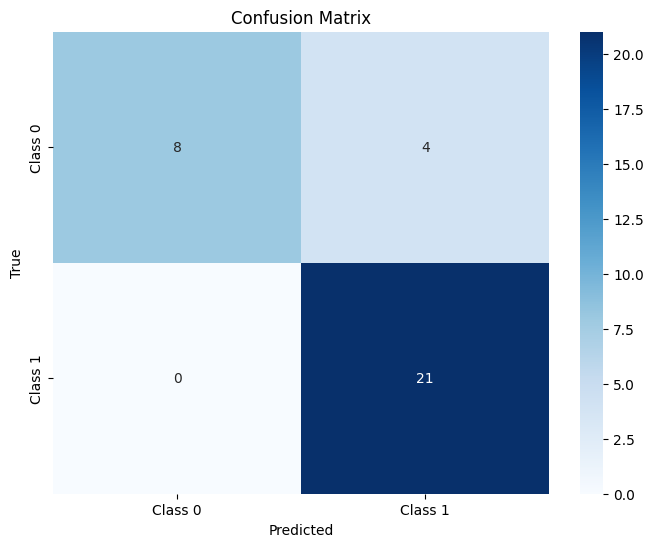

In [34]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Tree Diagram

<Axes: >

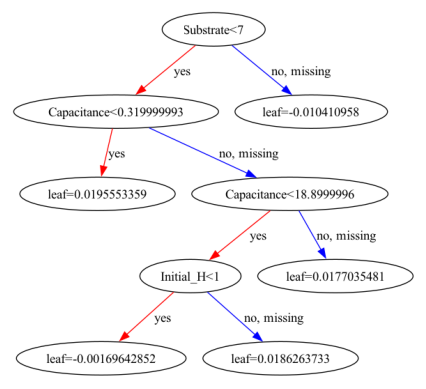

In [38]:
xgb.plot_tree(model)